In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [45]:
workers = 40
btch_sz = 2000
ngpu = 1

In [46]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Preprocessing

In [9]:
def preproc(file, file_to_save):
    data = pd.read_csv(file)
    
    signal = torch.tensor(data.signal.values)
    signal = 2*(signal-signal.min())/signal.max()-1
    
    data.signal = signal
    
    data.to_csv(file_to_save, index=False)

# preproc('data/train.csv', 'data/train_new.csv')
# preproc('data/test.csv', 'data/test_new.csv')

# Format Dataloaders

In [47]:
from dataUtils.CustomDataset import IonSwitchingDataset

ion_dataset_train = IonSwitchingDataset('data/train_new.csv', window_size=10000, slice_ratio=0.5)
ion_dataset_test = IonSwitchingDataset('data/test_new.csv', window_size=10000, slice_ratio=0.5, train=False)

In [48]:
dataloader = DataLoader(ion_dataset_train, batch_size=btch_sz, shuffle=True, num_workers=workers)
dataloader_test = DataLoader(ion_dataset_test, batch_size=btch_sz, shuffle=False, num_workers=workers)

In [49]:
batch = next(iter(dataloader))

In [50]:
batch['signal'].shape, batch['open_channels'].shape

(torch.Size([2000, 10000]), torch.Size([2000, 11]))

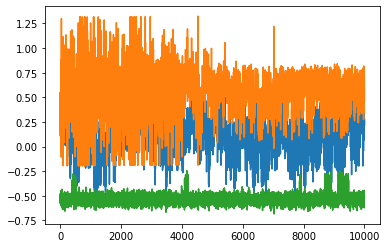

In [51]:
plt.plot(batch['signal'][0])
plt.plot(batch['signal'][1])
plt.plot(batch['signal'][2])
plt.show()

# Load Model

In [52]:
import models.FCC as FCC

model = FCC.OpenChannelsClassifier(1)
model.apply(FCC.weights_init)
print(sum(p.numel() for p in model.parameters()))
model.to(device)

126648843


OpenChannelsClassifier(
  (fc): Sequential(
    (0): Linear(in_features=10000, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=8192, out_features=4096, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=2048, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=2048, out_features=1024, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): LeakyReLU(negative_slope=0.01)
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=256, out_features=64, bias=True)
    (19): LeakyReLU(negative_s

In [53]:
model(batch['signal'].to(device).float()).shape

torch.Size([2000, 11])

# Optimirez and Criterion Loss

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [55]:
train_losses = np.array([])
train_accurasy = np.array([])

# Training Loop

In [56]:
num_epochs = 1
monit_res = 30
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        signal, labels = batch['signal'], batch['open_channels']
        signal = signal.to(device).float()
        labels = labels.to(device).float()
        output = model(signal)
        
        loss = criterion(output, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        
        
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)            
            train_accurasy = np.append(train_accurasy, accurasy)

            
            
            train_losses = np.append(train_losses, running_loss/monit_res)
            print('[{}/{}] [{}/{}], loss: {}, accyrasy: {}'.format(epoch,
                                                     num_epochs,
                                                     i,
                                                     len(dataloader),
                                                     round(running_loss/monit_res, 4),
                                                     round(accurasy, 4)
                                                    )
                 )
            running_loss = 0.0

[0/1] [29/2500], loss: 1.8557, accyrasy: 0.303
[0/1] [59/2500], loss: 1.7152, accyrasy: 0.3275
[0/1] [89/2500], loss: 1.6993, accyrasy: 0.322
[0/1] [119/2500], loss: 1.6871, accyrasy: 0.3455
[0/1] [149/2500], loss: 1.6901, accyrasy: 0.3355
[0/1] [179/2500], loss: 1.6784, accyrasy: 0.3335
[0/1] [209/2500], loss: 1.6697, accyrasy: 0.339
[0/1] [239/2500], loss: 1.6571, accyrasy: 0.3195
[0/1] [269/2500], loss: 1.6496, accyrasy: 0.332
[0/1] [299/2500], loss: 1.6284, accyrasy: 0.3185
[0/1] [329/2500], loss: 1.6687, accyrasy: 0.2325
[0/1] [359/2500], loss: 1.6558, accyrasy: 0.3365
[0/1] [389/2500], loss: 1.6262, accyrasy: 0.321
[0/1] [419/2500], loss: 1.61, accyrasy: 0.356
[0/1] [449/2500], loss: 1.5983, accyrasy: 0.3745
[0/1] [479/2500], loss: 1.6435, accyrasy: 0.3495
[0/1] [509/2500], loss: 1.6125, accyrasy: 0.33
[0/1] [539/2500], loss: 1.6013, accyrasy: 0.3705
[0/1] [569/2500], loss: 1.5859, accyrasy: 0.3405
[0/1] [599/2500], loss: 1.6354, accyrasy: 0.3505
[0/1] [629/2500], loss: 1.6264, a

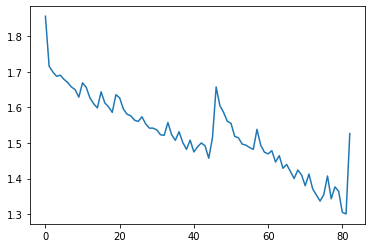

In [57]:
plt.plot(train_losses)
plt.show()

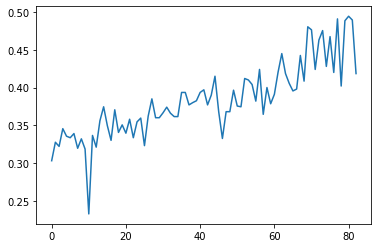

In [58]:
plt.plot(train_accurasy)
plt.show()

# Prediction

In [61]:
model.eval()
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_test):
    
    signal = batch['signal']
    signal = signal.to(device).float()
    
    with torch.no_grad():
        output = model(signal)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, predicted_idx.float()), 0)
    
    if i%50 == 49:
        print('[{}/{}]'.format(i, len(dataloader_test)))

[49/1000]
[99/1000]
[149/1000]
[199/1000]
[249/1000]
[299/1000]
[349/1000]
[399/1000]
[449/1000]
[499/1000]
[549/1000]
[599/1000]
[649/1000]
[699/1000]
[749/1000]
[799/1000]
[849/1000]
[899/1000]
[949/1000]
[999/1000]


In [64]:
prediction = prediction.cpu().detach().numpy()

In [65]:
np.save('prediction/prediction', prediction)